In [20]:
import numpy as np
import os
import time
# Initialize B_init and W_init with small values
def initialize_B_W(M, rank=20):
    """
    Initialize B and W matrices for NMF with small random values.
    
    Parameters:
        M (numpy.ndarray): Input magnitude matrix.
        rank (int): Rank of the factorization.
        
    Returns:
        B_init (numpy.ndarray): Initialized basis matrix.
        W_init (numpy.ndarray): Initialized weights matrix.
    """
    eps = 1e-3
    rows, cols = M.shape
    B_init = np.random.rand(rows, rank) * 100  + eps # Small random values
    W_init = np.random.rand(rank, cols) * 100 + eps # Small random values
    return B_init, W_init

# Load M matrices from saved files
def load_M_matrices(output_path, track_names):
    """
    Load M matrices from the specified output path for given track names.
    
    Parameters:
        output_path (str): Path to the directory containing the saved .npz files.
        track_names (list): List of track names to load.
        
    Returns:
        M_matrices (dict): Dictionary of track names and their corresponding M matrices.
    """
    M_matrices = {}
    for track in track_names:
        file_path = os.path.join(output_path, f"{track}_200sec.npz")
        if os.path.exists(file_path):
            data = np.load(file_path)
            M_matrices[track] = data['magnitude']
            print(f"Loaded M matrix for {track}, shape: {M_matrices[track].shape}.")
        else:
            print(f"File not found: {file_path}. Skipping.")
    return M_matrices

# Path to saved spectrograms and track names
output_path = r"C:\Users\sunre\Desktop\outputtracks"
track_names = ["vocals", "bass", "drums", "other", "mixture"]

# Load M matrices
M_matrices = load_M_matrices(output_path, track_names)

# Initialize B_init and W_init for each track
B_W_initializations = {}
rank = 50  # Adjust rank as needed
for track, M in M_matrices.items():
    B_init, W_init = initialize_B_W(M, rank=rank)
    B_W_initializations[track] = (B_init, W_init)
    print(f"Initialized B and W for {track}, B shape: {B_init.shape}, W shape: {W_init.shape}.")

# Results are now stored in B_W_initializations
print("Initialization complete!")


Loaded M matrix for vocals, shape: (1025, 34380).
Loaded M matrix for bass, shape: (1025, 34380).
Loaded M matrix for drums, shape: (1025, 34380).
Loaded M matrix for other, shape: (1025, 34380).
Loaded M matrix for mixture, shape: (1025, 34380).
Initialized B and W for vocals, B shape: (1025, 50), W shape: (50, 34380).
Initialized B and W for bass, B shape: (1025, 50), W shape: (50, 34380).
Initialized B and W for drums, B shape: (1025, 50), W shape: (50, 34380).
Initialized B and W for other, B shape: (1025, 50), W shape: (50, 34380).
Initialized B and W for mixture, B shape: (1025, 50), W shape: (50, 34380).
Initialization complete!


In [21]:
# Define the KL divergence function
def KL_divergence(M, B, W):
    """
    Compute the KL divergence between M and B@W.
    
    Parameters:
        M (numpy.ndarray): Input magnitude matrix.
        B (numpy.ndarray): Basis matrix.
        W (numpy.ndarray): Weights matrix.
        
    Returns:
        float: KL divergence value.
    """
    eps = 1e-8
    M = np.maximum(M, eps)
    B = np.maximum(B, eps)
    W = np.maximum(W, eps)
    return np.sum(M * np.log(M / (B @ W)) - M + B @ W)

# Modify NMF_train to print KL divergence every 50 iterations
def NMF_train_verbose(M, B_init, W_init, n_iter=200):
    """
    Perform NMF training using KL-divergence with verbose output.
    
    Parameters:
        M (numpy.ndarray): Input magnitude matrix.
        B_init (numpy.ndarray): Initialized basis matrix.
        W_init (numpy.ndarray): Initialized weights matrix.
        n_iter (int): Number of iterations.
        
    Returns:
        B (numpy.ndarray): Trained basis matrix.
        W (numpy.ndarray): Trained weights matrix.
    """
    eps = 1e-6
    B = B_init
    W = W_init
    for i in range(n_iter):
        # Update rules for B and W
        B = B * (M / (eps + (B @ W)) @ W.T) / (eps + np.ones_like(M) @ W.T)
        W = W * (B.T @ (M / (eps + B @ W))) / (eps + B.T @ np.ones_like(M))
        
        # Print KL divergence every 50 iterations
        if i % 5 == 0:
            #save the B and W matrices as csv files
            np.savetxt('B.csv', B, delimiter=',')
            np.savetxt('W.csv', W, delimiter=',')
            
            kl_div = KL_divergence(M, B, W)
            print(f"Iteration {i}, KL divergence: {kl_div:.6f}")
    
    return B, W

# Apply verbose NMF_train to each track
trained_B_W_verbose = {}

for track, (B_init, W_init) in B_W_initializations.items():
    # print the track name
    print(f"Training NMF for {track} with verbose output...")
    
    timerun = time.time()
    
    M = M_matrices[track]
    print(f"Training NMF for {track} with verbose output...")
    B, W = NMF_train_verbose(M, B_init, W_init, n_iter=100)
    trained_B_W_verbose[track] = (B, W)
    
    timerun = time.time() - timerun
    print(f"Training complete for {track}. Final B shape: {B.shape}, W shape: {W.shape}. Time taken: {timerun}.")
    
    # Save the trained B and W matrices
    np.savetxt(f'{track}_B.csv', B, delimiter=',')
    np.savetxt(f'{track}_W.csv', W, delimiter=',')
    
    
    
    print(f"Training complete for {track}. Final B shape: {B.shape}, W shape: {W.shape}.")

print("NMF training with verbose output complete for all tracks!")


Training NMF for vocals with verbose output...
Training NMF for vocals with verbose output...
Iteration 0, KL divergence: 7045989.441455
Iteration 5, KL divergence: 5966964.384080
Iteration 10, KL divergence: 3204459.243397
Iteration 15, KL divergence: 2312037.001023
Iteration 20, KL divergence: 1931252.270391
Iteration 25, KL divergence: 1738166.590200
Iteration 30, KL divergence: 1628564.857803
Iteration 35, KL divergence: 1564273.717108
Iteration 40, KL divergence: 1523228.230481
Iteration 45, KL divergence: 1494064.844535
Iteration 50, KL divergence: 1471228.449940
Iteration 55, KL divergence: 1451544.010631
Iteration 60, KL divergence: 1433939.484290
Iteration 65, KL divergence: 1418850.843525
Iteration 70, KL divergence: 1406465.782913
Iteration 75, KL divergence: 1396117.489365
Iteration 80, KL divergence: 1387232.794572
Iteration 85, KL divergence: 1379480.966513
Iteration 90, KL divergence: 1372571.074072
Iteration 95, KL divergence: 1366334.731799
Training complete for vocals

In [22]:
import numpy as np

def separate_signals_multitrack(M_mixed, B_vocals, B_bass, B_drums, B_other, n_iter):
    """
    Separate mixed signals into their respective components using provided basis matrices.
    
    Parameters:
        M_mixed (numpy.ndarray): Magnitude spectrogram of the mixed signal.
        B_vocals (numpy.ndarray): Basis matrix for vocals.
        B_bass (numpy.ndarray): Basis matrix for bass.
        B_drums (numpy.ndarray): Basis matrix for drums.
        B_other (numpy.ndarray): Basis matrix for other components.
        n_iter (int): Number of iterations for NMF optimization.
        
    Returns:
        M_vocals, M_bass, M_drums, M_other: Separated magnitude spectrograms for each component.
    """
    # Concatenate basis matrices
    B = np.concatenate((B_vocals, B_bass, B_drums, B_other), axis=1)
    
    # Initialize W_mixed with small random values
    W_mixed = np.maximum(np.random.rand(B.shape[1], M_mixed.shape[1]), 1e-8)
    
    print("Initial shapes:")
    print("W_mixed:", W_mixed.shape)
    print("B:", B.shape)
    
    for i in range(n_iter):
        # Update W_mixed
        W_mixed = W_mixed * (B.T @ (M_mixed / (B @ W_mixed))) / (B.T @ np.ones_like(M_mixed))
        
        if i % 20 == 0:
            kl_div = np.sum(M_mixed * np.log(M_mixed / (B @ W_mixed)) - M_mixed + (B @ W_mixed))
            print(f"Iteration {i}, KL divergence: {kl_div:.6f}")
    
    # Split W_mixed into respective components
    idx_vocals = B_vocals.shape[1]
    idx_bass = idx_vocals + B_bass.shape[1]
    idx_drums = idx_bass + B_drums.shape[1]
    
    W_vocals = W_mixed[0:idx_vocals, :]
    W_bass = W_mixed[idx_vocals:idx_bass, :]
    W_drums = W_mixed[idx_bass:idx_drums, :]
    W_other = W_mixed[idx_drums:, :]
    # W_nonvocals = W_mixed[idx_vocals:, :]
    
    # print("Final shapes:")
    # print("W_vocals:", W_vocals.shape)
    # print("W_bass:", W_bass.shape)
    # print("W_drums:", W_drums.shape)
    # print("W_other:", W_other.shape)
    
    # Reconstruct the magnitude spectrograms for each component
    M_vocals = B_vocals @ W_vocals
    M_bass = B_bass @ W_bass
    M_drums = B_drums @ W_drums
    M_other = B_other @ W_other
    
    return M_vocals, M_bass, M_drums, M_other

# The function is ready for use. You can pass trained B matrices and a mixed signal's spectrogram to separate components.


In [25]:
import librosa as lb
import  soundfile as sf

testpath = r"H:\My Drive\Courses\Fall2024\MLSP\Project\MLSP_Project\full_track_short_21s.mp3"

# Load the mixed signal's magnitude spectrogram 
y_mixed, sr = lb.load(testpath, sr = None)
spectrogram_mixed = lb.stft(y_mixed, n_fft = 2048, hop_length = 256, center = False, win_length = 2048)
M_mixed = np.abs(spectrogram_mixed)
phase_mixed = spectrogram_mixed / (M_mixed + 1e-8)

# Load the trained B matrices
B_vocals = np.loadtxt('vocals_B.csv', delimiter=',')
B_bass = np.loadtxt('bass_B.csv', delimiter=',')
B_drums = np.loadtxt('drums_B.csv', delimiter=',')
B_other = np.loadtxt('other_B.csv', delimiter=',')

# Separate the mixed signal into components
M_vocals, M_bass, M_drums, M_other = separate_signals_multitrack(M_mixed, B_vocals, B_bass, B_drums, B_other, n_iter=100)

# Save the separated components as audio files (use the phase information from the mixed signal) using soundfile library
y_vocals = lb.istft(M_vocals * phase_mixed, hop_length=256, win_length=2048)
sf.write('vocals.wav', y_vocals, sr)

y_bass = lb.istft(M_bass * phase_mixed, hop_length=256, win_length=2048)
sf.write('bass.wav', y_bass, sr)

y_drums = lb.istft(M_drums * phase_mixed, hop_length=256, win_length=2048)
sf.write('drums.wav', y_drums, sr)

y_other = lb.istft(M_other * phase_mixed, hop_length=256, win_length=2048)
sf.write('other.wav', y_other, sr)
print("Separation complete! Audio files saved.")




Initial shapes:
W_mixed: (200, 3734)
B: (1025, 200)
Iteration 0, KL divergence: 52127.856735
Iteration 20, KL divergence: 23600.412823
Iteration 40, KL divergence: 22682.370936
Iteration 60, KL divergence: 22390.737197
Iteration 80, KL divergence: 22257.285048
Final shapes:
W_vocals: (50, 3734)
W_bass: (50, 3734)
W_drums: (50, 3734)
W_other: (50, 3734)
Separation complete! Audio files saved.


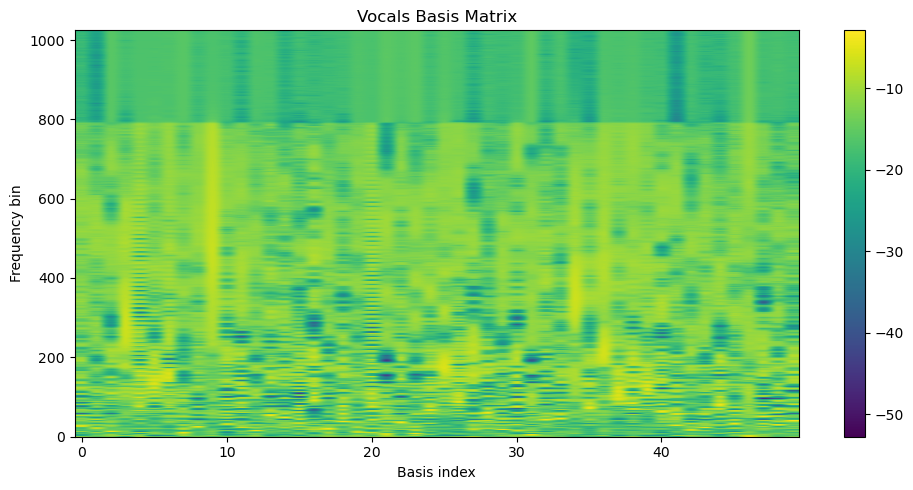

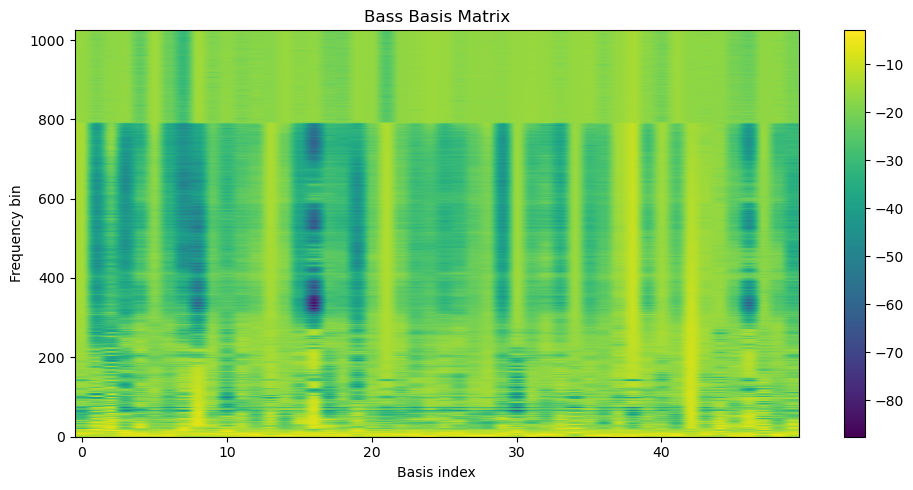

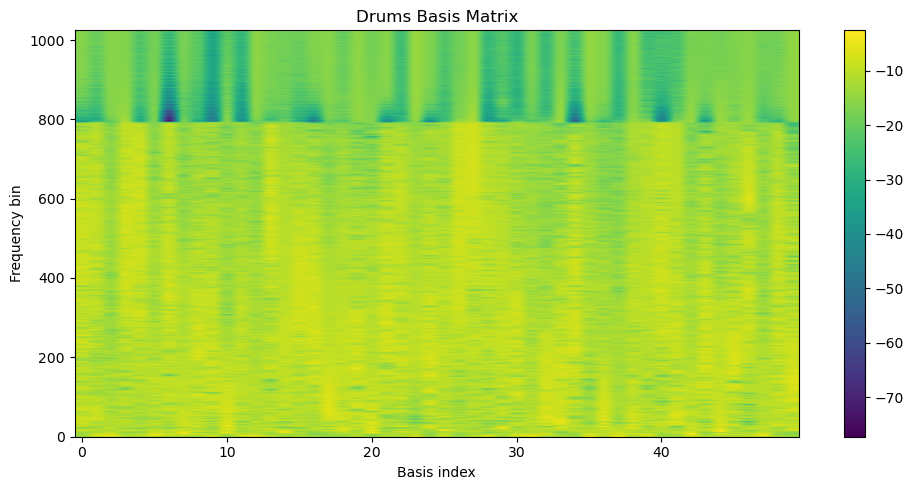

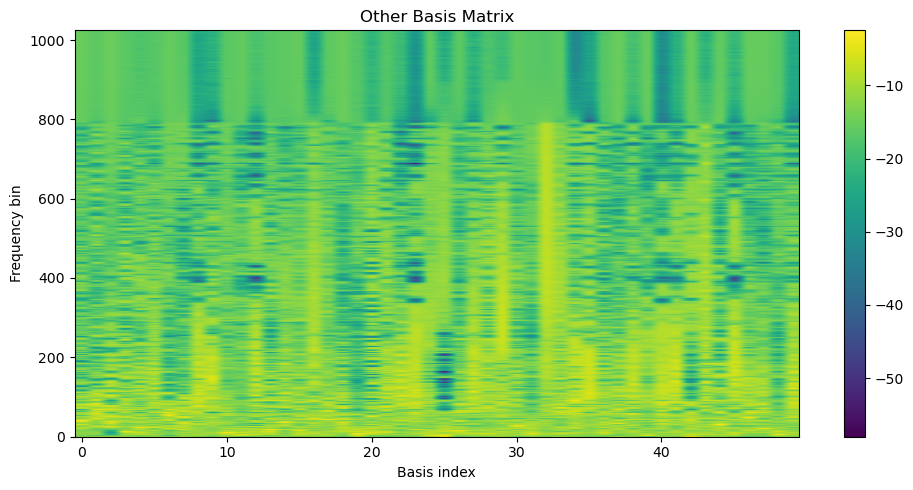

In [27]:
# plot the bases as images
import matplotlib.pyplot as plt

def plot_bases(B, title):
    """
    Plot the basis matrix as images.
    
    Parameters:
        B (numpy.ndarray): Basis matrix.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(np.log(B), aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Basis index')
    plt.ylabel('Frequency bin')
    plt.tight_layout()
    plt.show()
    
# Plot the basis matrices for each track
plot_bases(B_vocals, title='Vocals Basis Matrix')
plot_bases(B_bass, title='Bass Basis Matrix')
plot_bases(B_drums, title='Drums Basis Matrix')
plot_bases(B_other, title='Other Basis Matrix')


In [30]:
trainset = r"C:\Users\sunre\Desktop\songs\train"
trainfiles = os.listdir(trainset)

for trainfile in trainfiles:
    print(os.path.join(trainset, trainfile))
    trainpath = os.path.join(trainset, trainfile, 'mixture.wav')
    # Load the mixed signal's magnitude spectrogram 
    y_mixed, sr = lb.load(trainpath, sr = None)
    spectrogram_mixed = lb.stft(y_mixed, n_fft = 2048, hop_length = 256, center = False, win_length = 2048)
    M_mixed = np.abs(spectrogram_mixed)
    phase_mixed = spectrogram_mixed / (M_mixed + 1e-8)

    # Separate the mixed signal into components
    M_vocals, M_bass, M_drums, M_other = separate_signals_multitrack(M_mixed, B_vocals, B_bass, B_drums, B_other, n_iter=100)

    # Save the separated components as audio files (use the phase information from the mixed signal) using soundfile library
    y_vocals = lb.istft(M_vocals * phase_mixed, hop_length=256, win_length=2048)
    sf.write(f'train_{trainfile}_vocals_kl.wav', y_vocals, sr)

    y_bass = lb.istft(M_bass * phase_mixed, hop_length=256, win_length=2048)
    sf.write(f'train_{trainfile}_bass_kl.wav', y_bass, sr)

    y_drums = lb.istft(M_drums * phase_mixed, hop_length=256, win_length=2048)
    sf.write(f'train_{trainfile}_drums_kl.wav', y_drums, sr)

    y_other = lb.istft(M_other * phase_mixed, hop_length=256, win_length=2048)
    sf.write(f'train_{trainfile}_other_kl.wav', y_other, sr)
    print(f"Separation complete for {trainfile}! Audio files saved.")

C:\Users\sunre\Desktop\songs\train\1
Initial shapes:
W_mixed: (200, 3438)
B: (1025, 200)
Iteration 0, KL divergence: 648341.402216
Iteration 20, KL divergence: 299231.132237
Iteration 40, KL divergence: 287680.418496
Iteration 60, KL divergence: 283847.028452
Iteration 80, KL divergence: 281938.353662
Final shapes:
W_vocals: (50, 3438)
W_bass: (50, 3438)
W_drums: (50, 3438)
W_other: (50, 3438)
Separation complete for 1! Audio files saved.
C:\Users\sunre\Desktop\songs\train\10
Initial shapes:
W_mixed: (200, 3438)
B: (1025, 200)
Iteration 0, KL divergence: 390546.500748
Iteration 20, KL divergence: 160361.948189
Iteration 40, KL divergence: 153036.115934
Iteration 60, KL divergence: 150459.530056
Iteration 80, KL divergence: 149168.776128
Final shapes:
W_vocals: (50, 3438)
W_bass: (50, 3438)
W_drums: (50, 3438)
W_other: (50, 3438)
Separation complete for 10! Audio files saved.
C:\Users\sunre\Desktop\songs\train\2
Initial shapes:
W_mixed: (200, 3438)
B: (1025, 200)
Iteration 0, KL diverge

In [29]:
testset = r"C:\Users\sunre\Desktop\songs\test"
testfiles = os.listdir(testset)

for testfile in testfiles:
    print(os.path.join(testset, testfile))
    testpath = os.path.join(testset, testfile, 'mixture.wav')
    # Load the mixed signal's magnitude spectrogram 
    y_mixed, sr = lb.load(testpath, sr = None)
    spectrogram_mixed = lb.stft(y_mixed, n_fft = 2048, hop_length = 256, center = False, win_length = 2048)
    M_mixed = np.abs(spectrogram_mixed)
    phase_mixed = spectrogram_mixed / (M_mixed + 1e-8)

    # Separate the mixed signal into components
    M_vocals, M_bass, M_drums, M_other = separate_signals_multitrack(M_mixed, B_vocals, B_bass, B_drums, B_other, n_iter=100)

    # Save the separated components as audio files (use the phase information from the mixed signal) using soundfile library
    y_vocals = lb.istft(M_vocals * phase_mixed, hop_length=256, win_length=2048)
    sf.write(f'{testfile}_vocals_kl.wav', y_vocals, sr)

    y_bass = lb.istft(M_bass * phase_mixed, hop_length=256, win_length=2048)
    sf.write(f'{testfile}_bass_kl.wav', y_bass, sr)

    y_drums = lb.istft(M_drums * phase_mixed, hop_length=256, win_length=2048)
    sf.write(f'{testfile}_drums_kl.wav', y_drums, sr)

    y_other = lb.istft(M_other * phase_mixed, hop_length=256, win_length=2048)
    sf.write(f'{testfile}_other_kl.wav', y_other, sr)
    print(f"Separation complete for {testfile}! Audio files saved.")

C:\Users\sunre\Desktop\songs\test\1
Initial shapes:
W_mixed: (200, 3438)
B: (1025, 200)
Iteration 0, KL divergence: 717483.926777
Iteration 20, KL divergence: 353411.391405
Iteration 40, KL divergence: 339947.684201
Iteration 60, KL divergence: 334913.726680
Iteration 80, KL divergence: 332306.358714
Final shapes:
W_vocals: (50, 3438)
W_bass: (50, 3438)
W_drums: (50, 3438)
W_other: (50, 3438)
Separation complete for 1! Audio files saved.
C:\Users\sunre\Desktop\songs\test\10
Initial shapes:
W_mixed: (200, 3438)
B: (1025, 200)
Iteration 0, KL divergence: 905069.006670
Iteration 20, KL divergence: 470281.575525
Iteration 40, KL divergence: 454156.589673
Iteration 60, KL divergence: 448281.053436
Iteration 80, KL divergence: 445336.972684
Final shapes:
W_vocals: (50, 3438)
W_bass: (50, 3438)
W_drums: (50, 3438)
W_other: (50, 3438)
Separation complete for 10! Audio files saved.
C:\Users\sunre\Desktop\songs\test\2
Initial shapes:
W_mixed: (200, 3438)
B: (1025, 200)
Iteration 0, KL divergence